In [1]:
import pandas as pd

# Load the dataset
file_path = 'study2_associative_session_1_data_transformed.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()


Experiment   v1_mean   v2_mean   v3_mean  \
0  1000_associative_priming_part_1.dat  1.935601  1.897988 -1.732863   
1  1001_associative_priming_part_1.dat  2.342618  2.262226 -2.519849   
2  1002_associative_priming_part_1.dat  2.175385  2.308964 -1.702918   
3  1003_associative_priming_part_1.dat  2.392442  2.124618 -2.630450   
4  1004_associative_priming_part_1.dat  2.195662  1.479115 -1.550731   

    v4_mean   zr_mean    a_mean  ndt1_mean  ndt2_mean  ndt3_mean  ...  \
0 -1.574229  0.436154  1.211153   0.507427   0.536280   0.629706  ...   
1 -2.202129  0.515540  1.625730   0.526514   0.511458   0.569683  ...   
2 -1.512117  0.425207  1.414919   0.448710   0.511910   0.579726  ...   
3 -2.267339  0.495459  1.621787   0.477002   0.514564   0.542697  ...   
4 -2.039059  0.421449  1.120746   0.444256   0.434109   0.518621  ...   

                                                q4_E    ID  Task    Session  \
0  [1.111 1.097 1.088 1.239 1.039 1.055 1.287 1.863]  1000   APT  Session 1   
1                                      [1.456 1.232]  1001   APT  Session 1   
2                    [1.078 1.096 2.17  1.591 1.159]  1002   APT  Session 1   
3                                      [0.879 1.127]  1003   APT  Session 1   
4  [0.679 0.808 0.694 0.68  0.767 0.799 0.711 0.927]  1004   APT  Session 1   

   alpha_shifted  alpha_clipped  alpha_arcsin  alpha_mean_boxcox_after_arcsin  \
0       0.852549       0.852549      1.176679                        0.206721   
1       0.968048       0.968048      1.391080                        0.546470   
2       0.939964       0.939964      1.323254                        0.427655   
3       0.949432       0.949432      1.343984                        0.462817   
4       0.651135       0.651135      0.938935                       -0.057702   

  accuracy_arcsin accuracy_percentage_boxcox_after_arcsin  
0        1.279465                                0.441066  
1        1.420038                                0.825259  
2        1.338726                                0.586882  
3        1.427449                                0.849380  
4        1.261363                                0.400797  

[5 rows x 37 columns]

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('ldt_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean', 'v2_mean', 'zr_mean', 'a_mean', 'ndt_mean', 'sndt_mean', 
                   'alpha_mean', 'alpha_mean_boxcox_after_arcsin', 
                   'mean_log_rt', 'accuracy_percentage_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2', 'zr_mean': 'zr', 'a_mean': 'a', 
    'ndt_mean': 'ndt', 'sndt_mean': 'sndt', 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
# ... [rest of your code remains unchanged] ...

# Define the colormap for the heatmap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Create the visualization
fig, axn = plt.subplots(len(renamed_params), len(renamed_params), figsize=(20, 20))
cbar_ax = fig.add_axes([.91, .3, .03, .4])  # Adjust the position of the colorbar

for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        ax = axn[i, j]
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True, ax=ax)
            ax.set_title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False, ax=ax)
            if i == j + 1:
                ax.legend(loc='upper right', title='Outlier', prop={'size': 6})
            ax.set_title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            corr_value = correlation_matrix_renamed.iloc[i, j]
            color = cmap((corr_value + 1) / 2)
            ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
            ax.text(0.5, 0.5, f'{corr_value:.2f}', ha='center', va='center', fontsize=12)
            ax.axis('off')

# Create a colorbar
norm = plt.Normalize(vmin=-1, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar_ax.set_title('Correlation')

plt.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('LDT_S1_correlation_matrix_plot.png')  # Saves the plot to a file
plt.show()
plt.close()




FileNotFoundError: [Errno 2] No such file or directory: 'ldt_session_1_data_transformed.csv'

In [ ]:
import numpy as np
import scipy.stats as stats

# Define the safe Mahalanobis function
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Let's apply this to the first pair of parameters and check the result
pair = ['v1_mean', 'v2_mean']
data_pair = data[pair]

# Calculating Mahalanobis distance for the pair
mahal_distances = safe_mahalanobis(x=data_pair, data=data_pair)

# Determine the p-value threshold for outlier detection (p < 0.001)
p_value_threshold = 0.001

# Calculate the critical value for this p-value under the chi-squared distribution
critical_value = stats.chi2.ppf((1 - p_value_threshold), df=2)

# Identifying outliers
outliers = mahal_distances > critical_value

# Display the first few Mahalanobis distances and the outlier flags
mahal_distances[:5], outliers[:5]


In [ ]:
import numpy as np
import scipy.stats as stats

# Define the function for Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Select the first pair of parameters to demonstrate the process
params = ['v1_mean', 'v2_mean']
data_subset = data[params]

# Calculate the Mahalanobis distance for each observation
mahal_distances = safe_mahalanobis(x=data_subset, data=data_subset)

# Determine the threshold for outliers using the Chi-square distribution
p_value = 0.001
threshold = stats.chi2.ppf((1 - p_value), df=2)  # df is the number of variables, here 2

# Identify outliers
outliers = mahal_distances > threshold

# Print the number of outliers detected
num_outliers = np.sum(outliers)
num_outliers, threshold


In [ ]:
import numpy as np
import scipy.stats as stats

# Define the function for Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Select the first pair of parameters to demonstrate the process
params = ['v1_mean', 'v2_mean']
data_subset = data[params]

# Calculate the Mahalanobis distance for each observation
mahal_distances = safe_mahalanobis(x=data_subset, data=data_subset)

# Determine the threshold for outliers using the Chi-square distribution
p_value = 0.001
threshold = stats.chi2.ppf((1 - p_value), df=2)  # df is the number of variables, here 2

# Identify outliers
outliers = mahal_distances > threshold

# Print the number of outliers detected
num_outliers = np.sum(outliers)
num_outliers, threshold


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove outliers for the first pair
data_no_outliers = data_subset[~outliers]

# Calculate correlation for the first pair without outliers
correlation = data_no_outliers.corr().iloc[0, 1]

# Plotting to show the process
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot with outliers
sns.scatterplot(data=data_subset, x=params[0], y=params[1], ax=ax[0])
ax[0].set_title(f'Scatter Plot with Outliers\n({params[0]} vs {params[1]})')

# Scatter plot without outliers
sns.scatterplot(data=data_no_outliers, x=params[0], y=params[1], ax=ax[1])
ax[1].set_title(f'Scatter Plot without Outliers\n({params[0]} vs {params[1]})\nCorrelation: {correlation:.2f}')

plt.tight_layout()
plt.show()

correlation


In [3]:
from itertools import combinations

# List of all selected parameters
selected_params = ['v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
 'sndt_mean',
 'alpha_mean',
    'accuracy_percentage',
    'mean_log_rt',
    'alpha_mean_boxcox_after_arcsin',
    'accuracy_percentage_boxcox_after_arcsin']

# Preparing a DataFrame to store correlations
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)

# Calculate Mahalanobis distance and correlations for each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation  # Mirror the matrix

# Fill diagonal with NaN as we will put histograms there
np.fill_diagonal(correlation_matrix.values, np.nan)

correlation_matrix.head()  # Displaying the first few rows for review


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


NameError: name 'threshold' is not defined

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

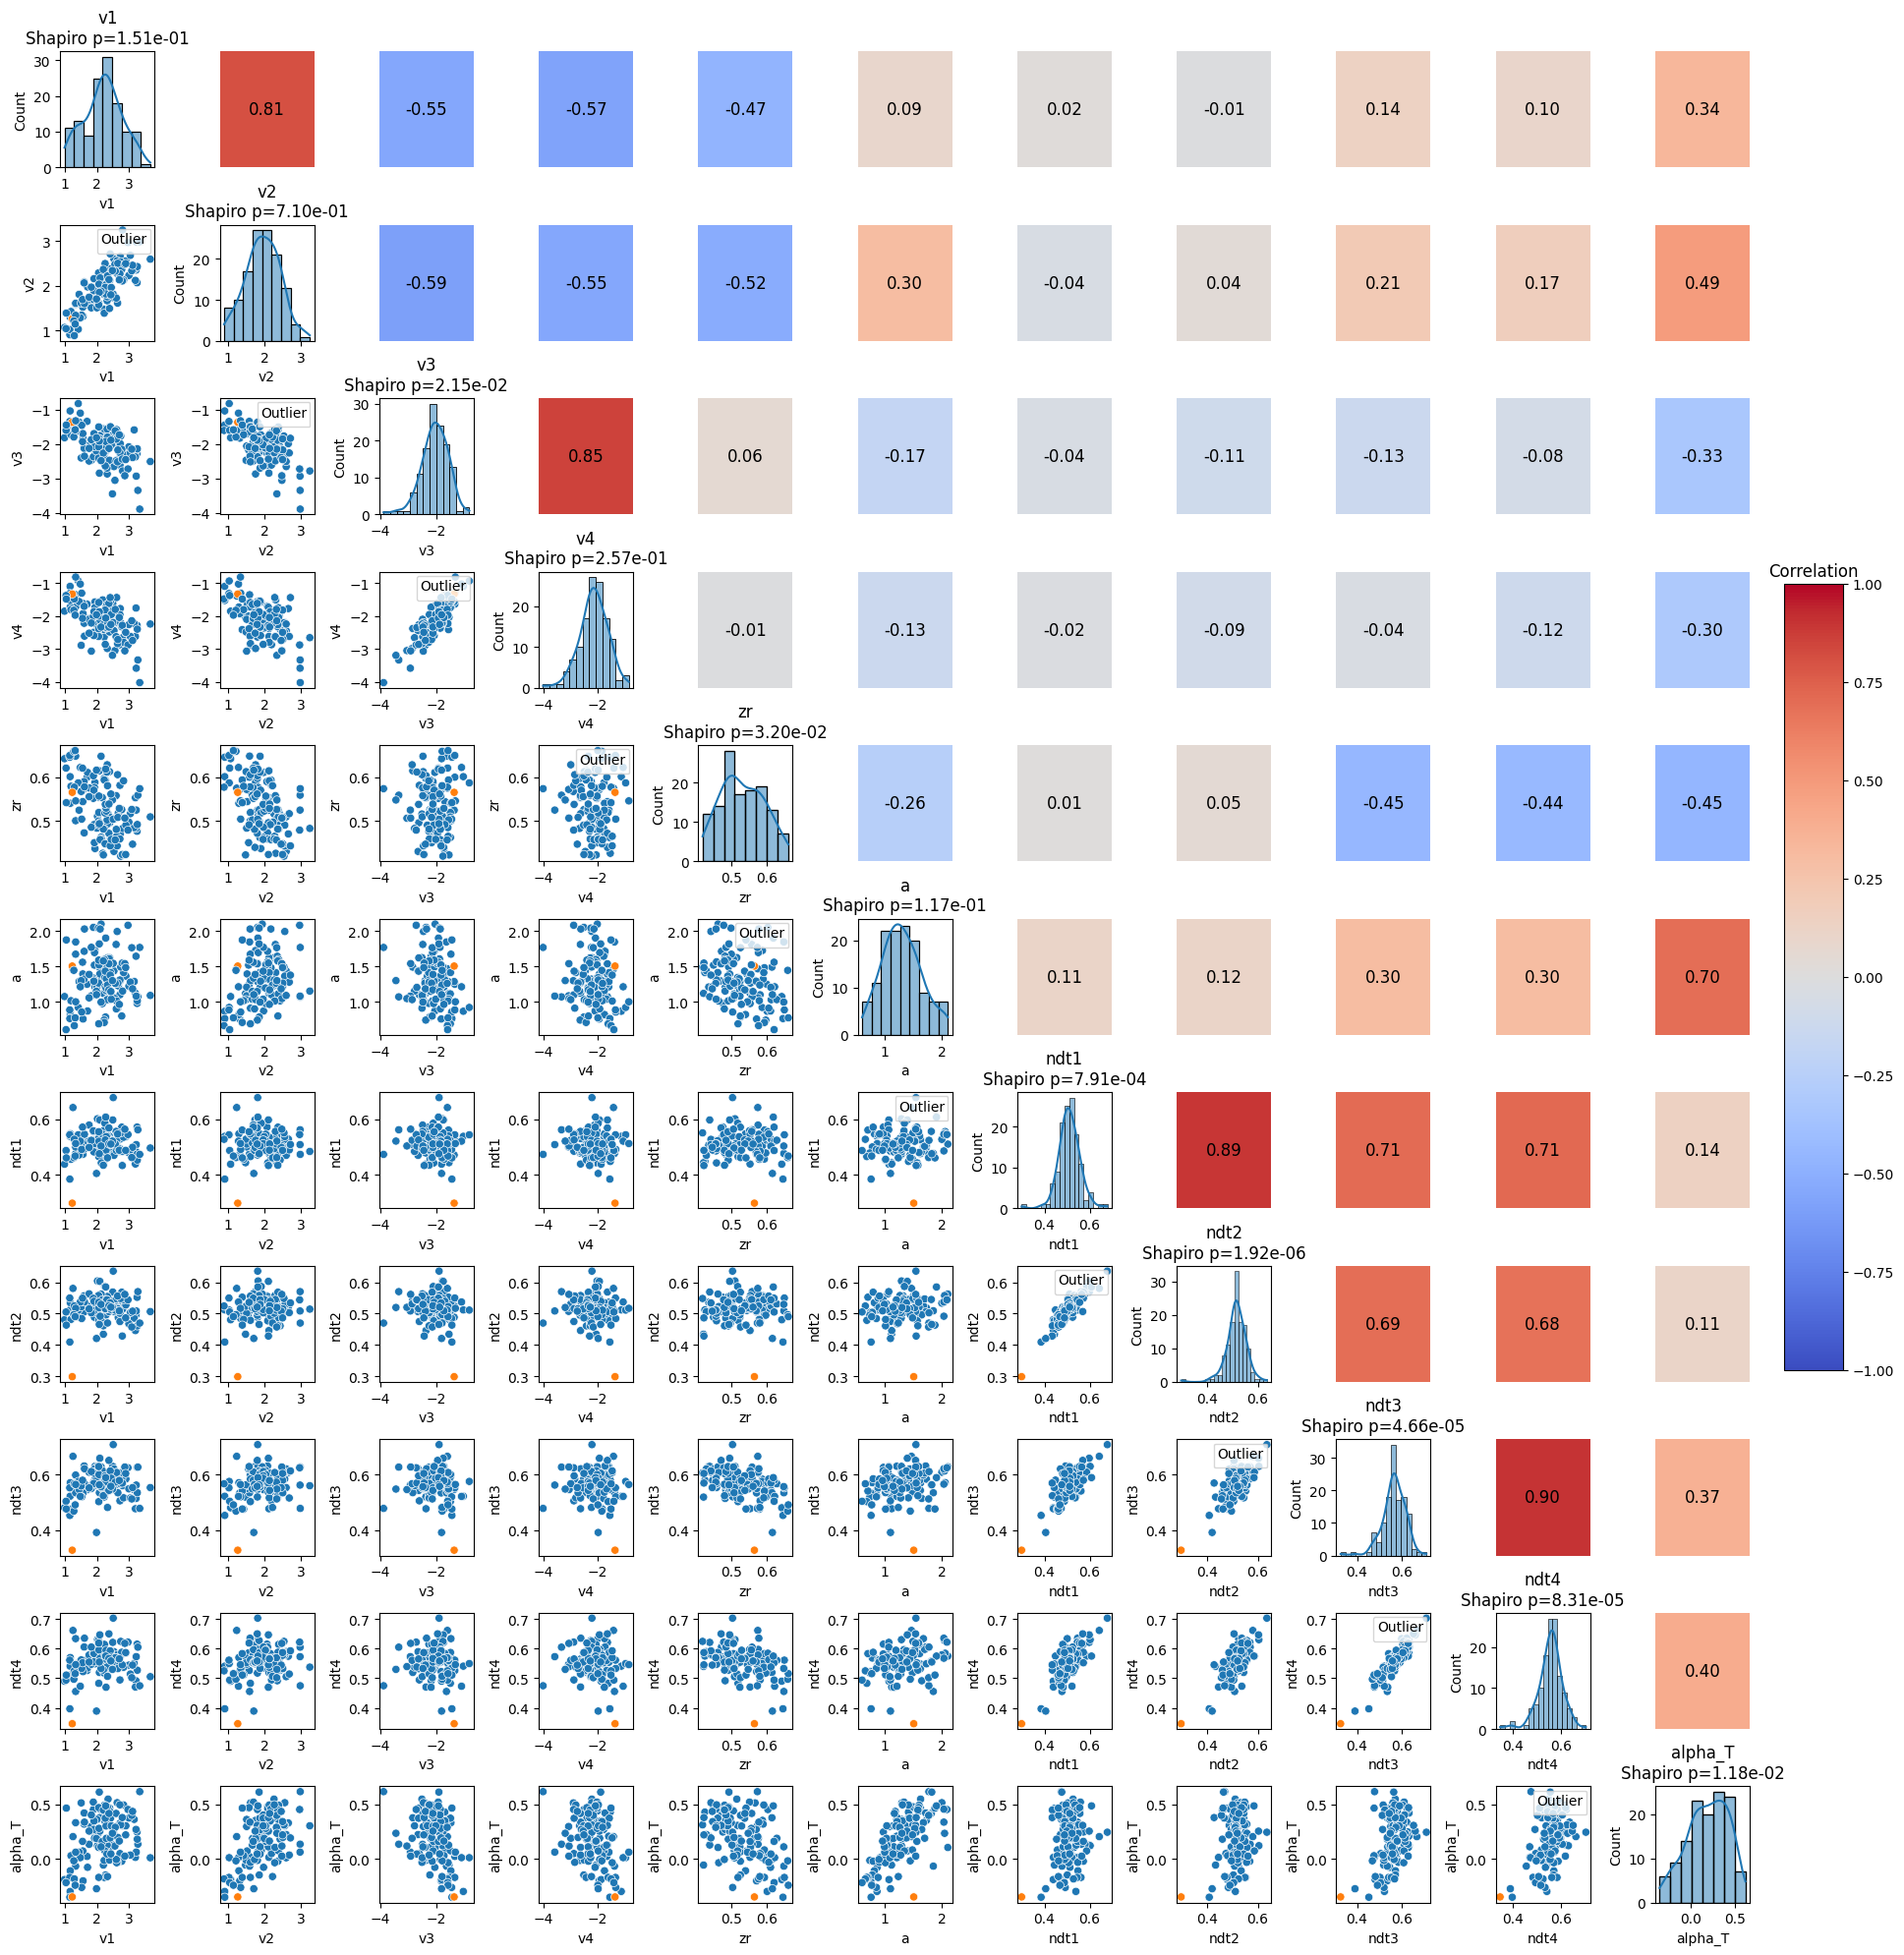

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('study2_associative_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
 #'sndt_mean',
 #'alpha_mean',
  #  'mean_log_rt',
    'alpha_mean_boxcox_after_arcsin',
   # 'accuracy_percentage_boxcox_after_arcsin'
                  ]

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2','v3_mean': 'v3','v4_mean': 'v4',
    'zr_mean': 'zr',
    'a_mean': 'a', 
    'ndt1_mean': 'ndt1','ndt2_mean': 'ndt2','ndt3_mean': 'ndt3','ndt4_mean': 'ndt4',
    #'sndt_mean': 'sndt', 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_T', 
   # 'mean_log_rt': 'mean_log_rt', 
   # 'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
# ... [rest of your code remains unchanged] ...

# Define the colormap for the heatmap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Create the visualization
fig, axn = plt.subplots(len(renamed_params), len(renamed_params), figsize=(20, 20))
cbar_ax = fig.add_axes([.91, .3, .03, .4])  # Adjust the position of the colorbar

for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        ax = axn[i, j]
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True, ax=ax)
            ax.set_title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False, ax=ax)
            if i == j + 1:
                ax.legend(loc='upper right', title='Outlier', prop={'size': 6})
            # ax.set_title(f'({param_j} vs {param_i})')
        else:
            corr_value = correlation_matrix_renamed.iloc[i, j]
            color = cmap((corr_value + 1) / 2)
            ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
            ax.text(0.5, 0.5, f'{corr_value:.2f}', ha='center', va='center', fontsize=12)
            ax.axis('off')

# Create a colorbar
norm = plt.Normalize(vmin=-1, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar_ax.set_title('Correlation')

plt.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('APT_S1_correlation_matrix_HeatMap_plot.png')  # Saves the plot to a file
plt.show()
plt.close()




/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

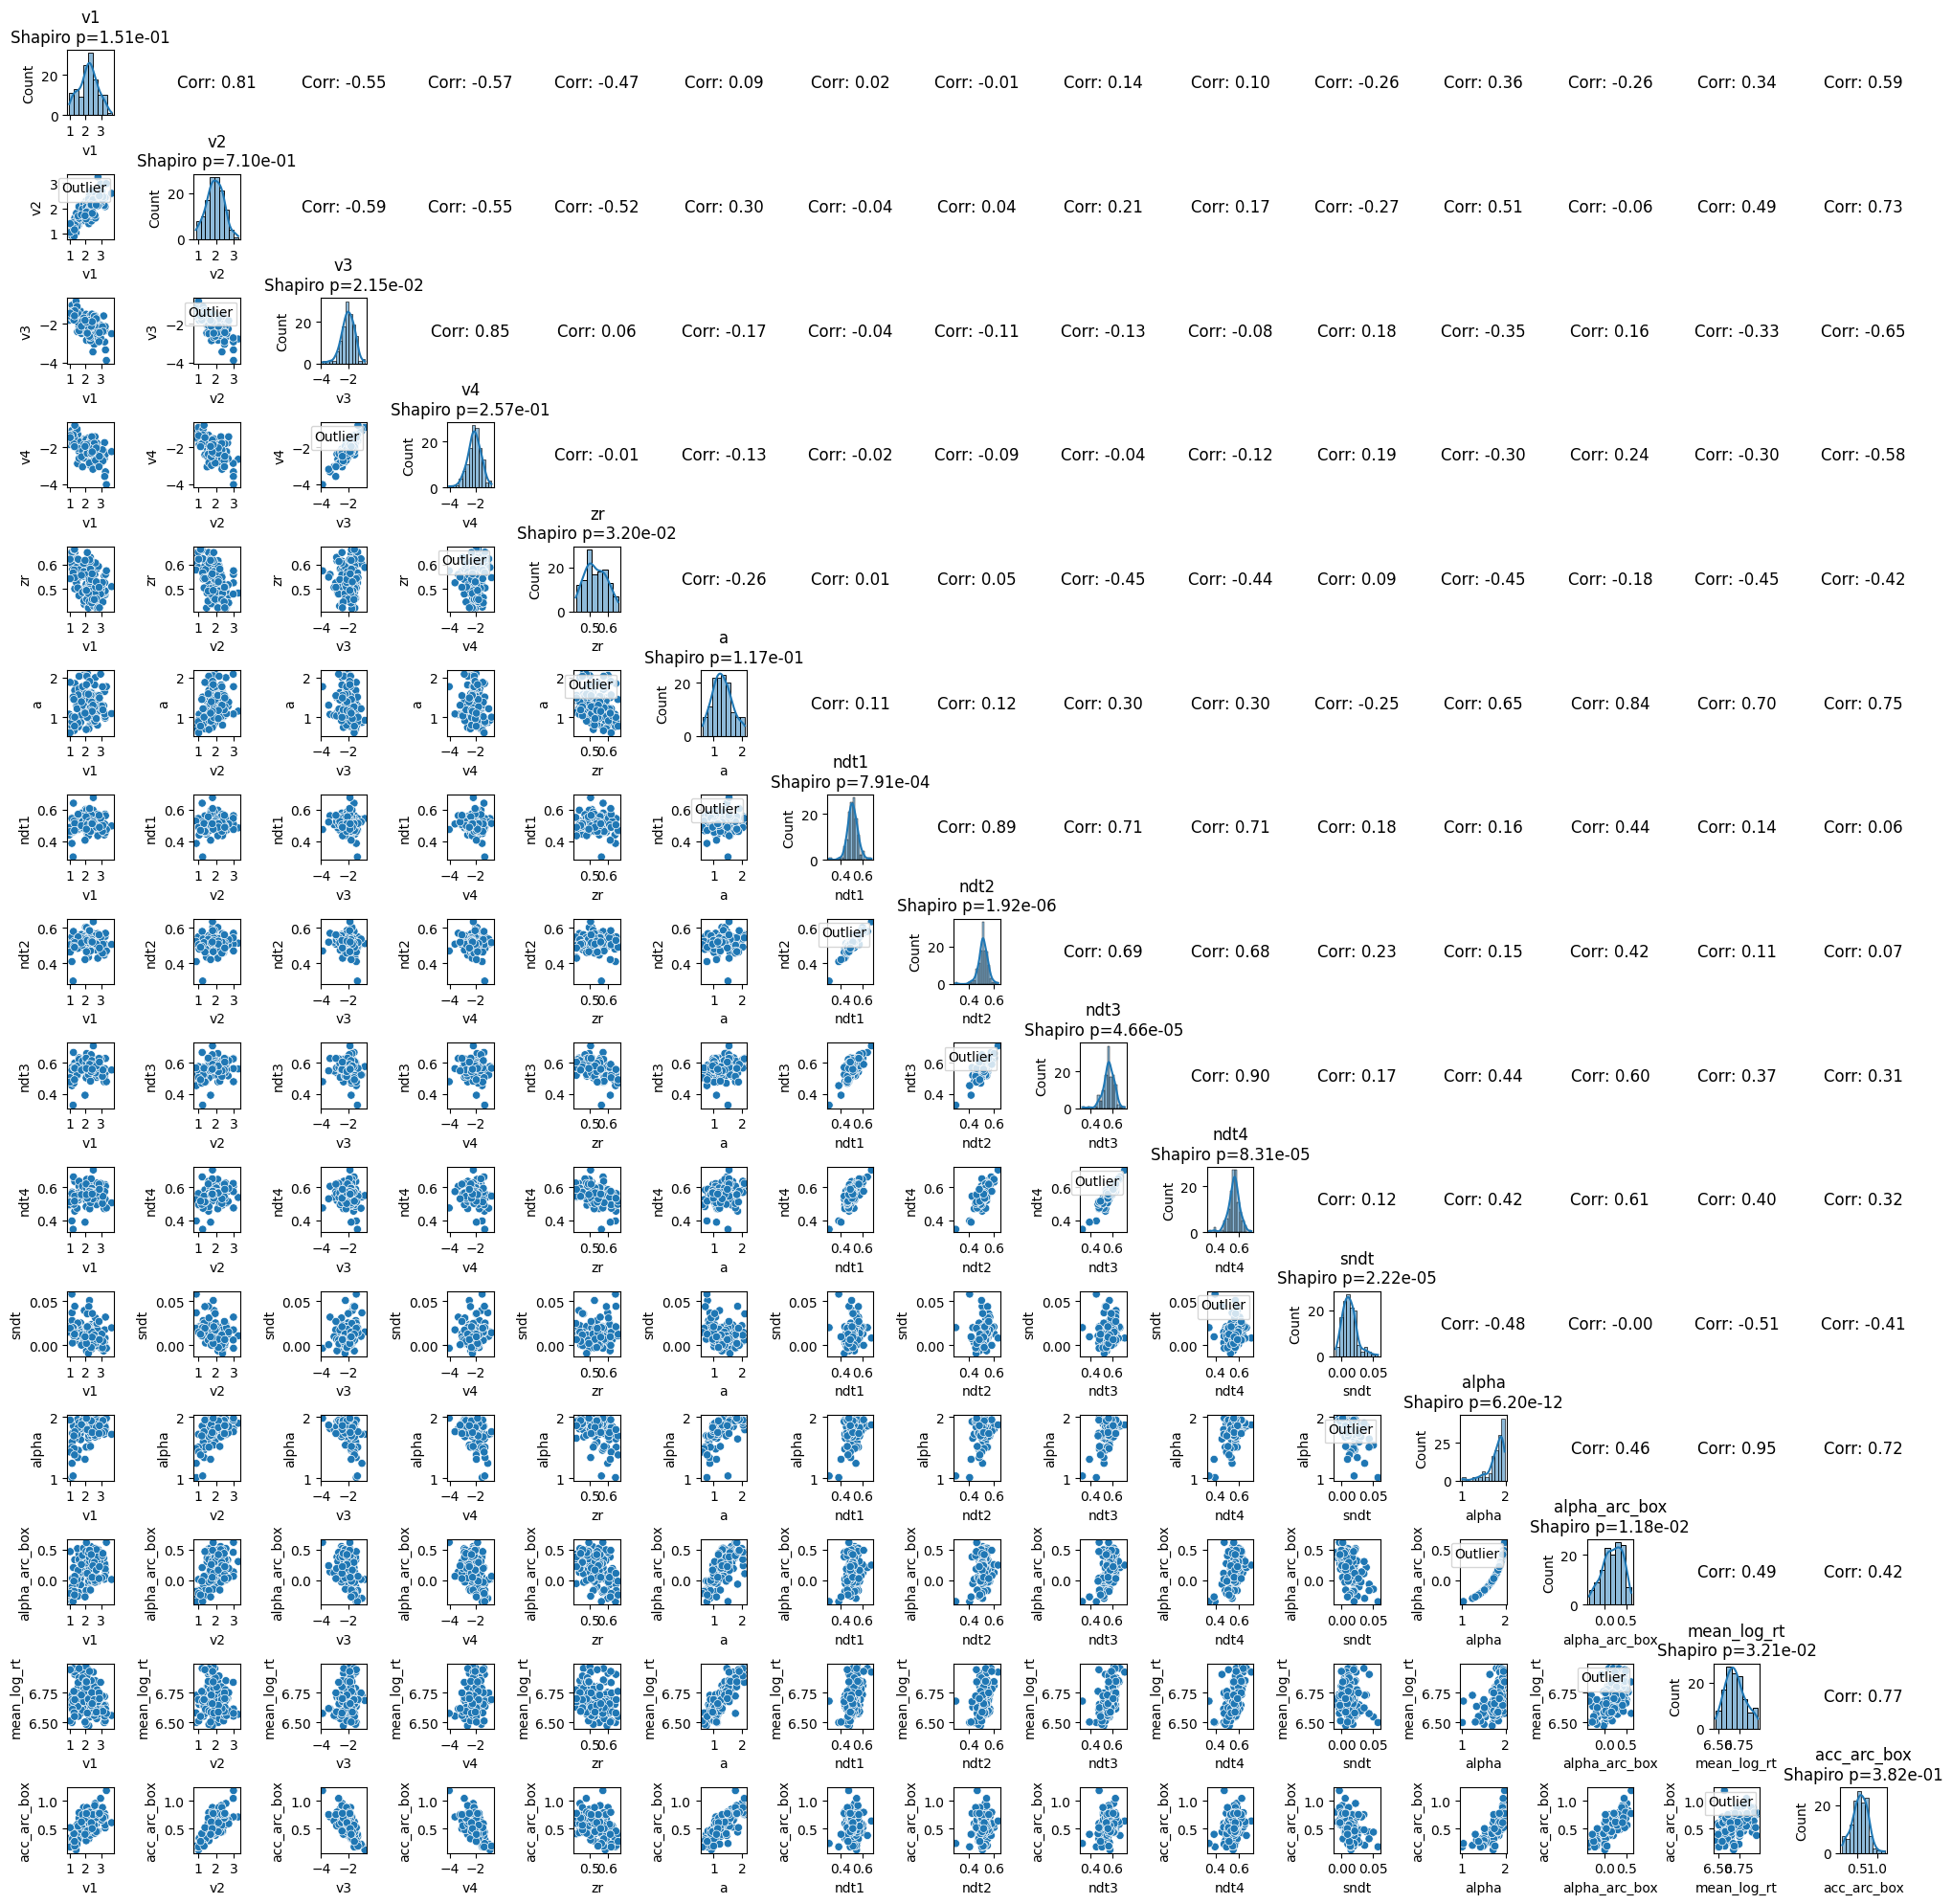

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('study2_associative_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
 'sndt_mean',
 'alpha_mean',
    'mean_log_rt',
    'alpha_mean_boxcox_after_arcsin',
    'accuracy_percentage_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2','v3_mean': 'v3','v4_mean': 'v4',
    'zr_mean': 'zr', 'a_mean': 'a', 
    'ndt1_mean': 'ndt1','ndt2_mean': 'ndt2','ndt3_mean': 'ndt3','ndt4_mean': 'ndt4',
    'sndt_mean': 'sndt', 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
          #  plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.show()
plt.savefig('APT_S1_correlation_matrix_plot.png')  # Saves the plot to a file
plt.close()



In [6]:
correlation_matrix_renamed.to_csv('Distinct_APT_s1_correlation_matrix.csv')

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

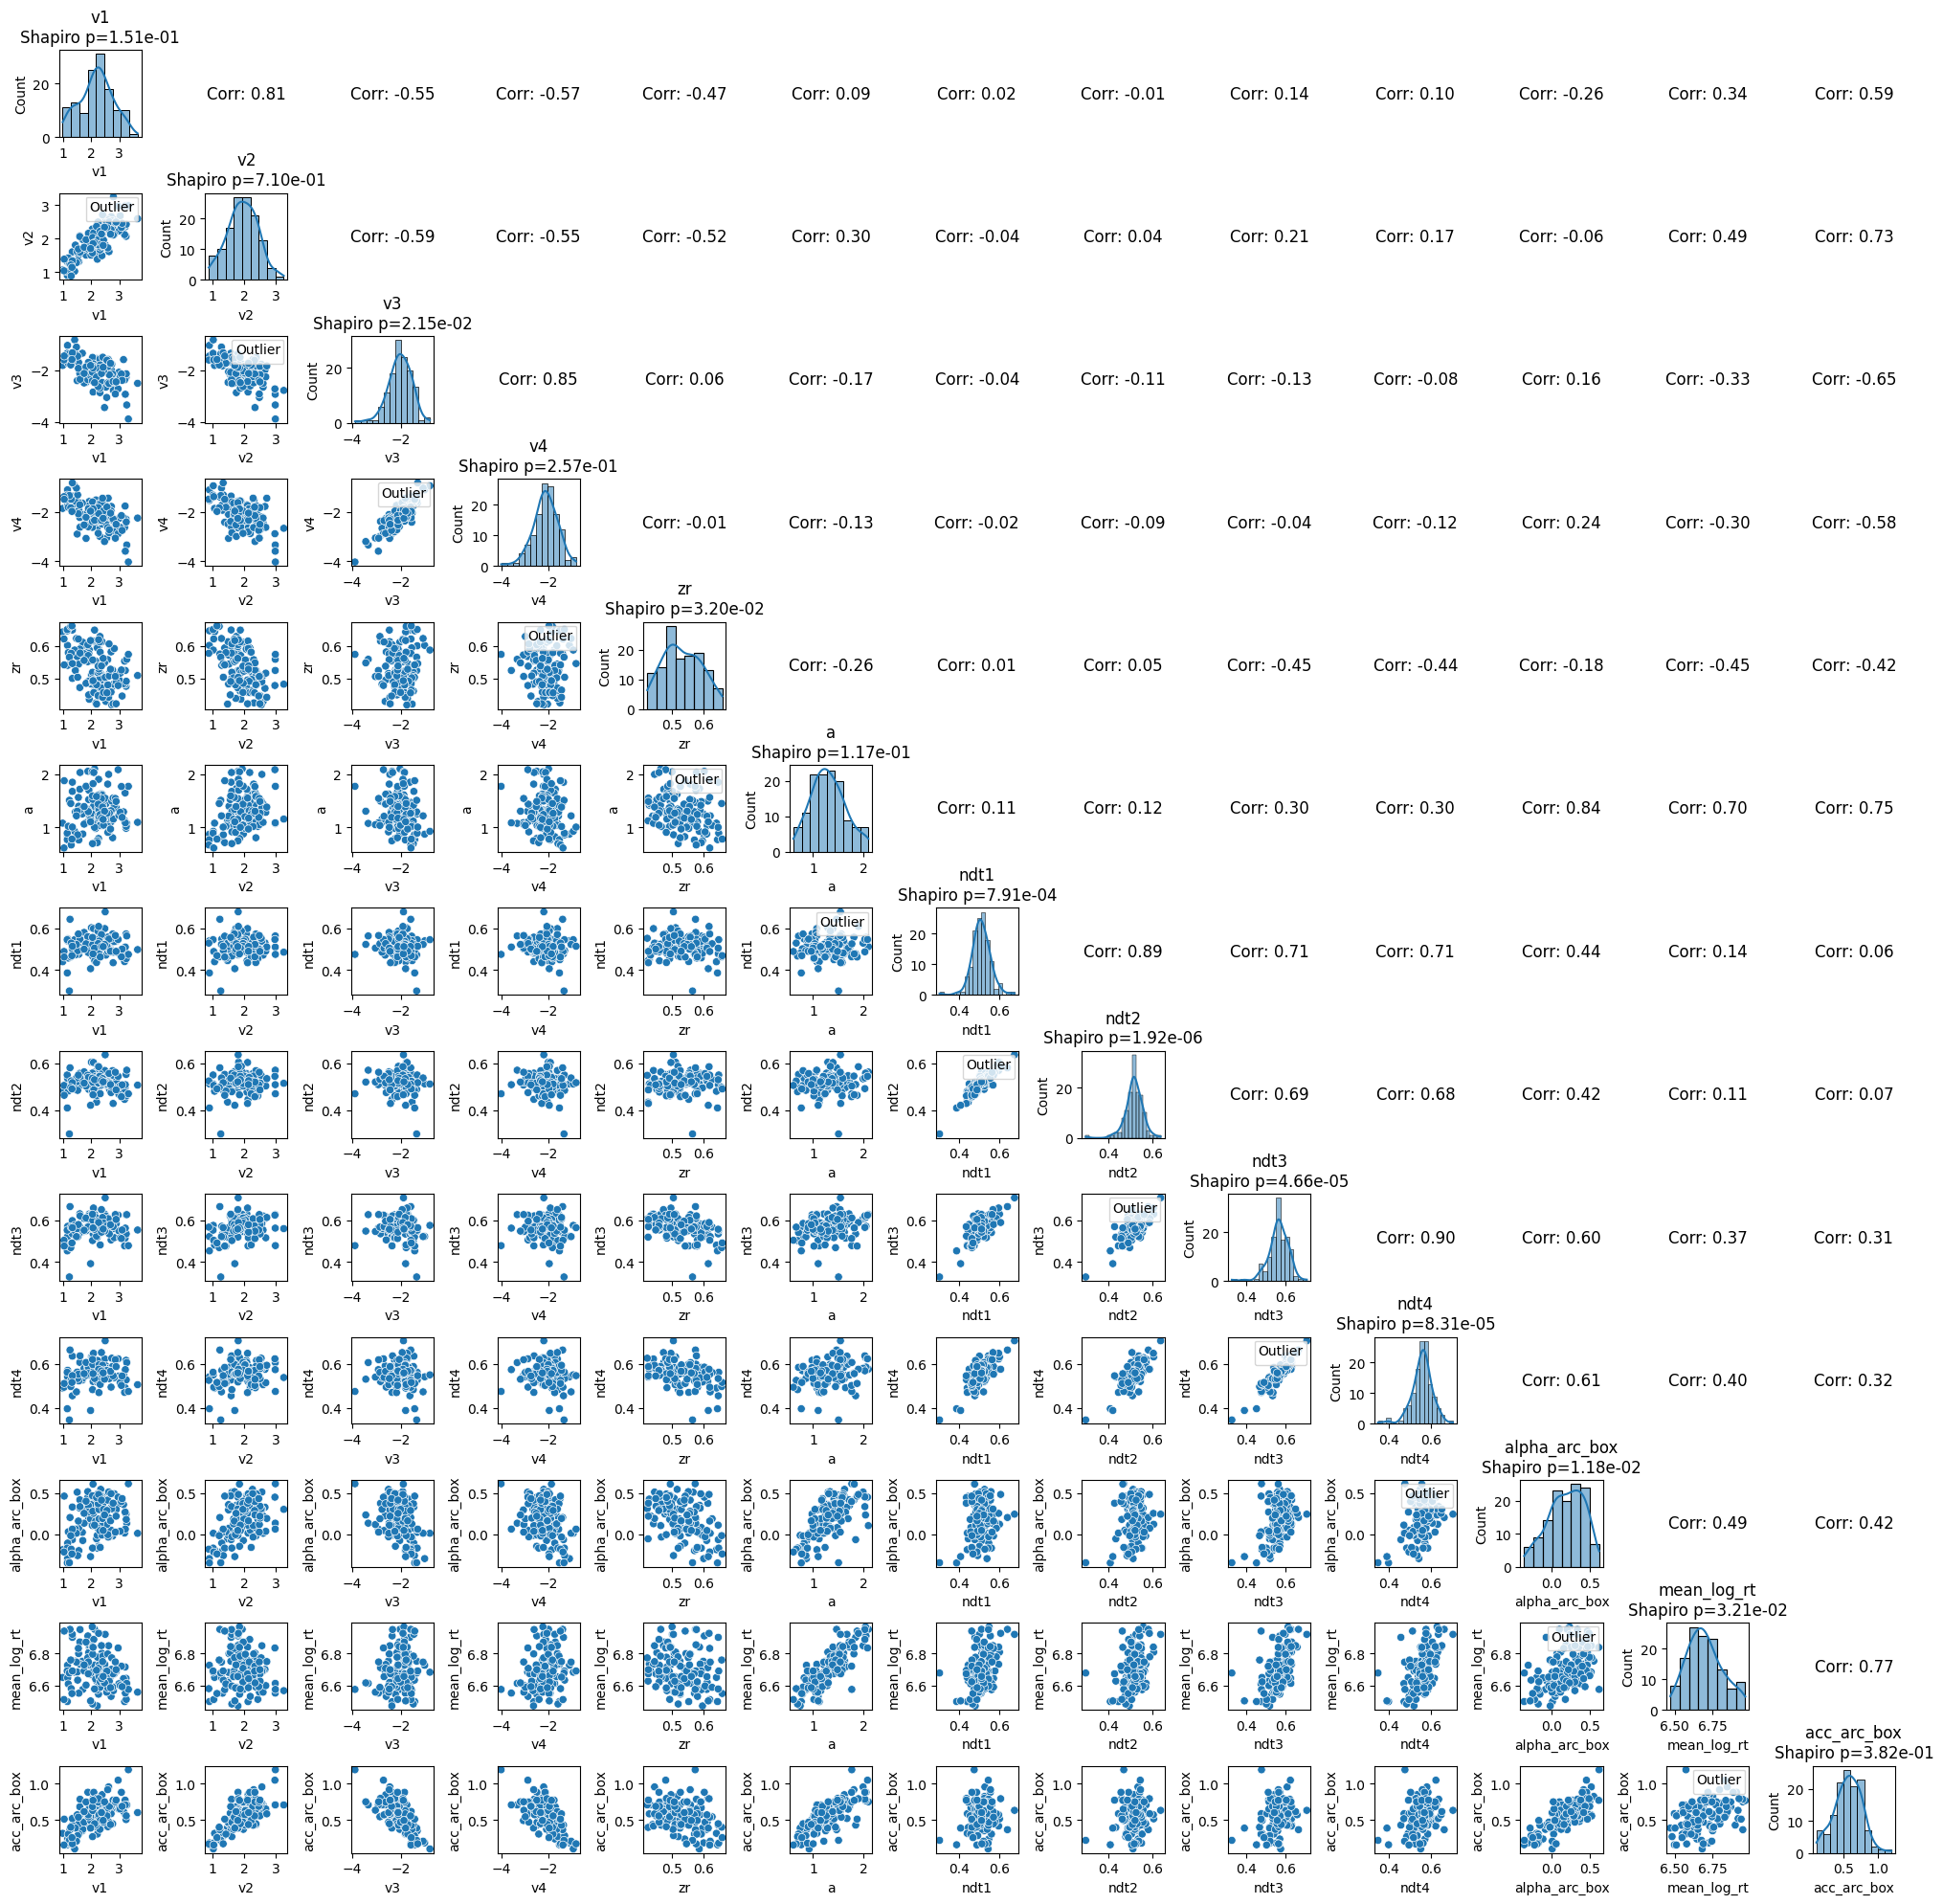

In [7]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('study2_associative_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
# 'sndt_mean',
# 'alpha_mean',
    'mean_log_rt',
    'alpha_mean_boxcox_after_arcsin',
    'accuracy_percentage_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2','v3_mean': 'v3','v4_mean': 'v4',
    'zr_mean': 'zr', 'a_mean': 'a', 
    'ndt1_mean': 'ndt1','ndt2_mean': 'ndt2','ndt3_mean': 'ndt3','ndt4_mean': 'ndt4',
    #'sndt_mean': 'sndt', 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
           # plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.savefig('APT_S1_correlation_matrix_plot.png')  # Saves the plot to a file
plt.show()
plt.close()



In [8]:
correlation_matrix_renamed

v1        v2        v3        v4        zr         a  \
v1                  NaN  0.811411 -0.552538 -0.572278 -0.472533  0.088523   
v2             0.811411       NaN -0.586018 -0.550648 -0.518992  0.302157   
v3            -0.552538 -0.586018       NaN  0.852226  0.060542 -0.172219   
v4            -0.572278 -0.550648  0.852226       NaN -0.009488 -0.125108   
zr            -0.472533 -0.518992  0.060542 -0.009488       NaN -0.255368   
a              0.088523  0.302157 -0.172219 -0.125108 -0.255368       NaN   
ndt1           0.017366 -0.041346 -0.042138 -0.020985  0.009348  0.114676   
ndt2          -0.014895   0.03714 -0.108154 -0.088236  0.048264  0.116802   
ndt3           0.138517   0.20508 -0.129189 -0.038042 -0.447354   0.29897   
ndt4           0.099597  0.165615 -0.075202 -0.115834 -0.436386  0.299719   
mean_log_rt   -0.258663 -0.062546  0.159223  0.243072 -0.179669  0.841234   
alpha_arc_box   0.33775  0.486768 -0.334871 -0.304832 -0.454728  0.695112   
acc_arc_box    0.590433  0.729768 -0.647848 -0.578578 -0.422107  0.754255   

                   ndt1      ndt2      ndt3      ndt4 mean_log_rt  \
v1             0.017366 -0.014895  0.138517  0.099597   -0.258663   
v2            -0.041346   0.03714   0.20508  0.165615   -0.062546   
v3            -0.042138 -0.108154 -0.129189 -0.075202    0.159223   
v4            -0.020985 -0.088236 -0.038042 -0.115834    0.243072   
zr             0.009348  0.048264 -0.447354 -0.436386   -0.179669   
a              0.114676  0.116802   0.29897  0.299719    0.841234   
ndt1                NaN  0.890822  0.709826  0.713064    0.442477   
ndt2           0.890822       NaN  0.691055  0.675371    0.421089   
ndt3           0.709826  0.691055       NaN  0.903214    0.598858   
ndt4           0.713064  0.675371  0.903214       NaN     0.60873   
mean_log_rt    0.442477  0.421089  0.598858   0.60873         NaN   
alpha_arc_box  0.141851   0.11256  0.371873  0.398752    0.485613   
acc_arc_box    0.055056  0.070279  0.309231  0.316315    0.417856   

              alpha_arc_box acc_arc_box  
v1                  0.33775    0.590433  
v2                 0.486768    0.729768  
v3                -0.334871   -0.647848  
v4                -0.304832   -0.578578  
zr                -0.454728   -0.422107  
a                  0.695112    0.754255  
ndt1               0.141851    0.055056  
ndt2                0.11256    0.070279  
ndt3               0.371873    0.309231  
ndt4               0.398752    0.316315  
mean_log_rt        0.485613    0.417856  
alpha_arc_box           NaN    0.773897  
acc_arc_box        0.773897         NaN

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

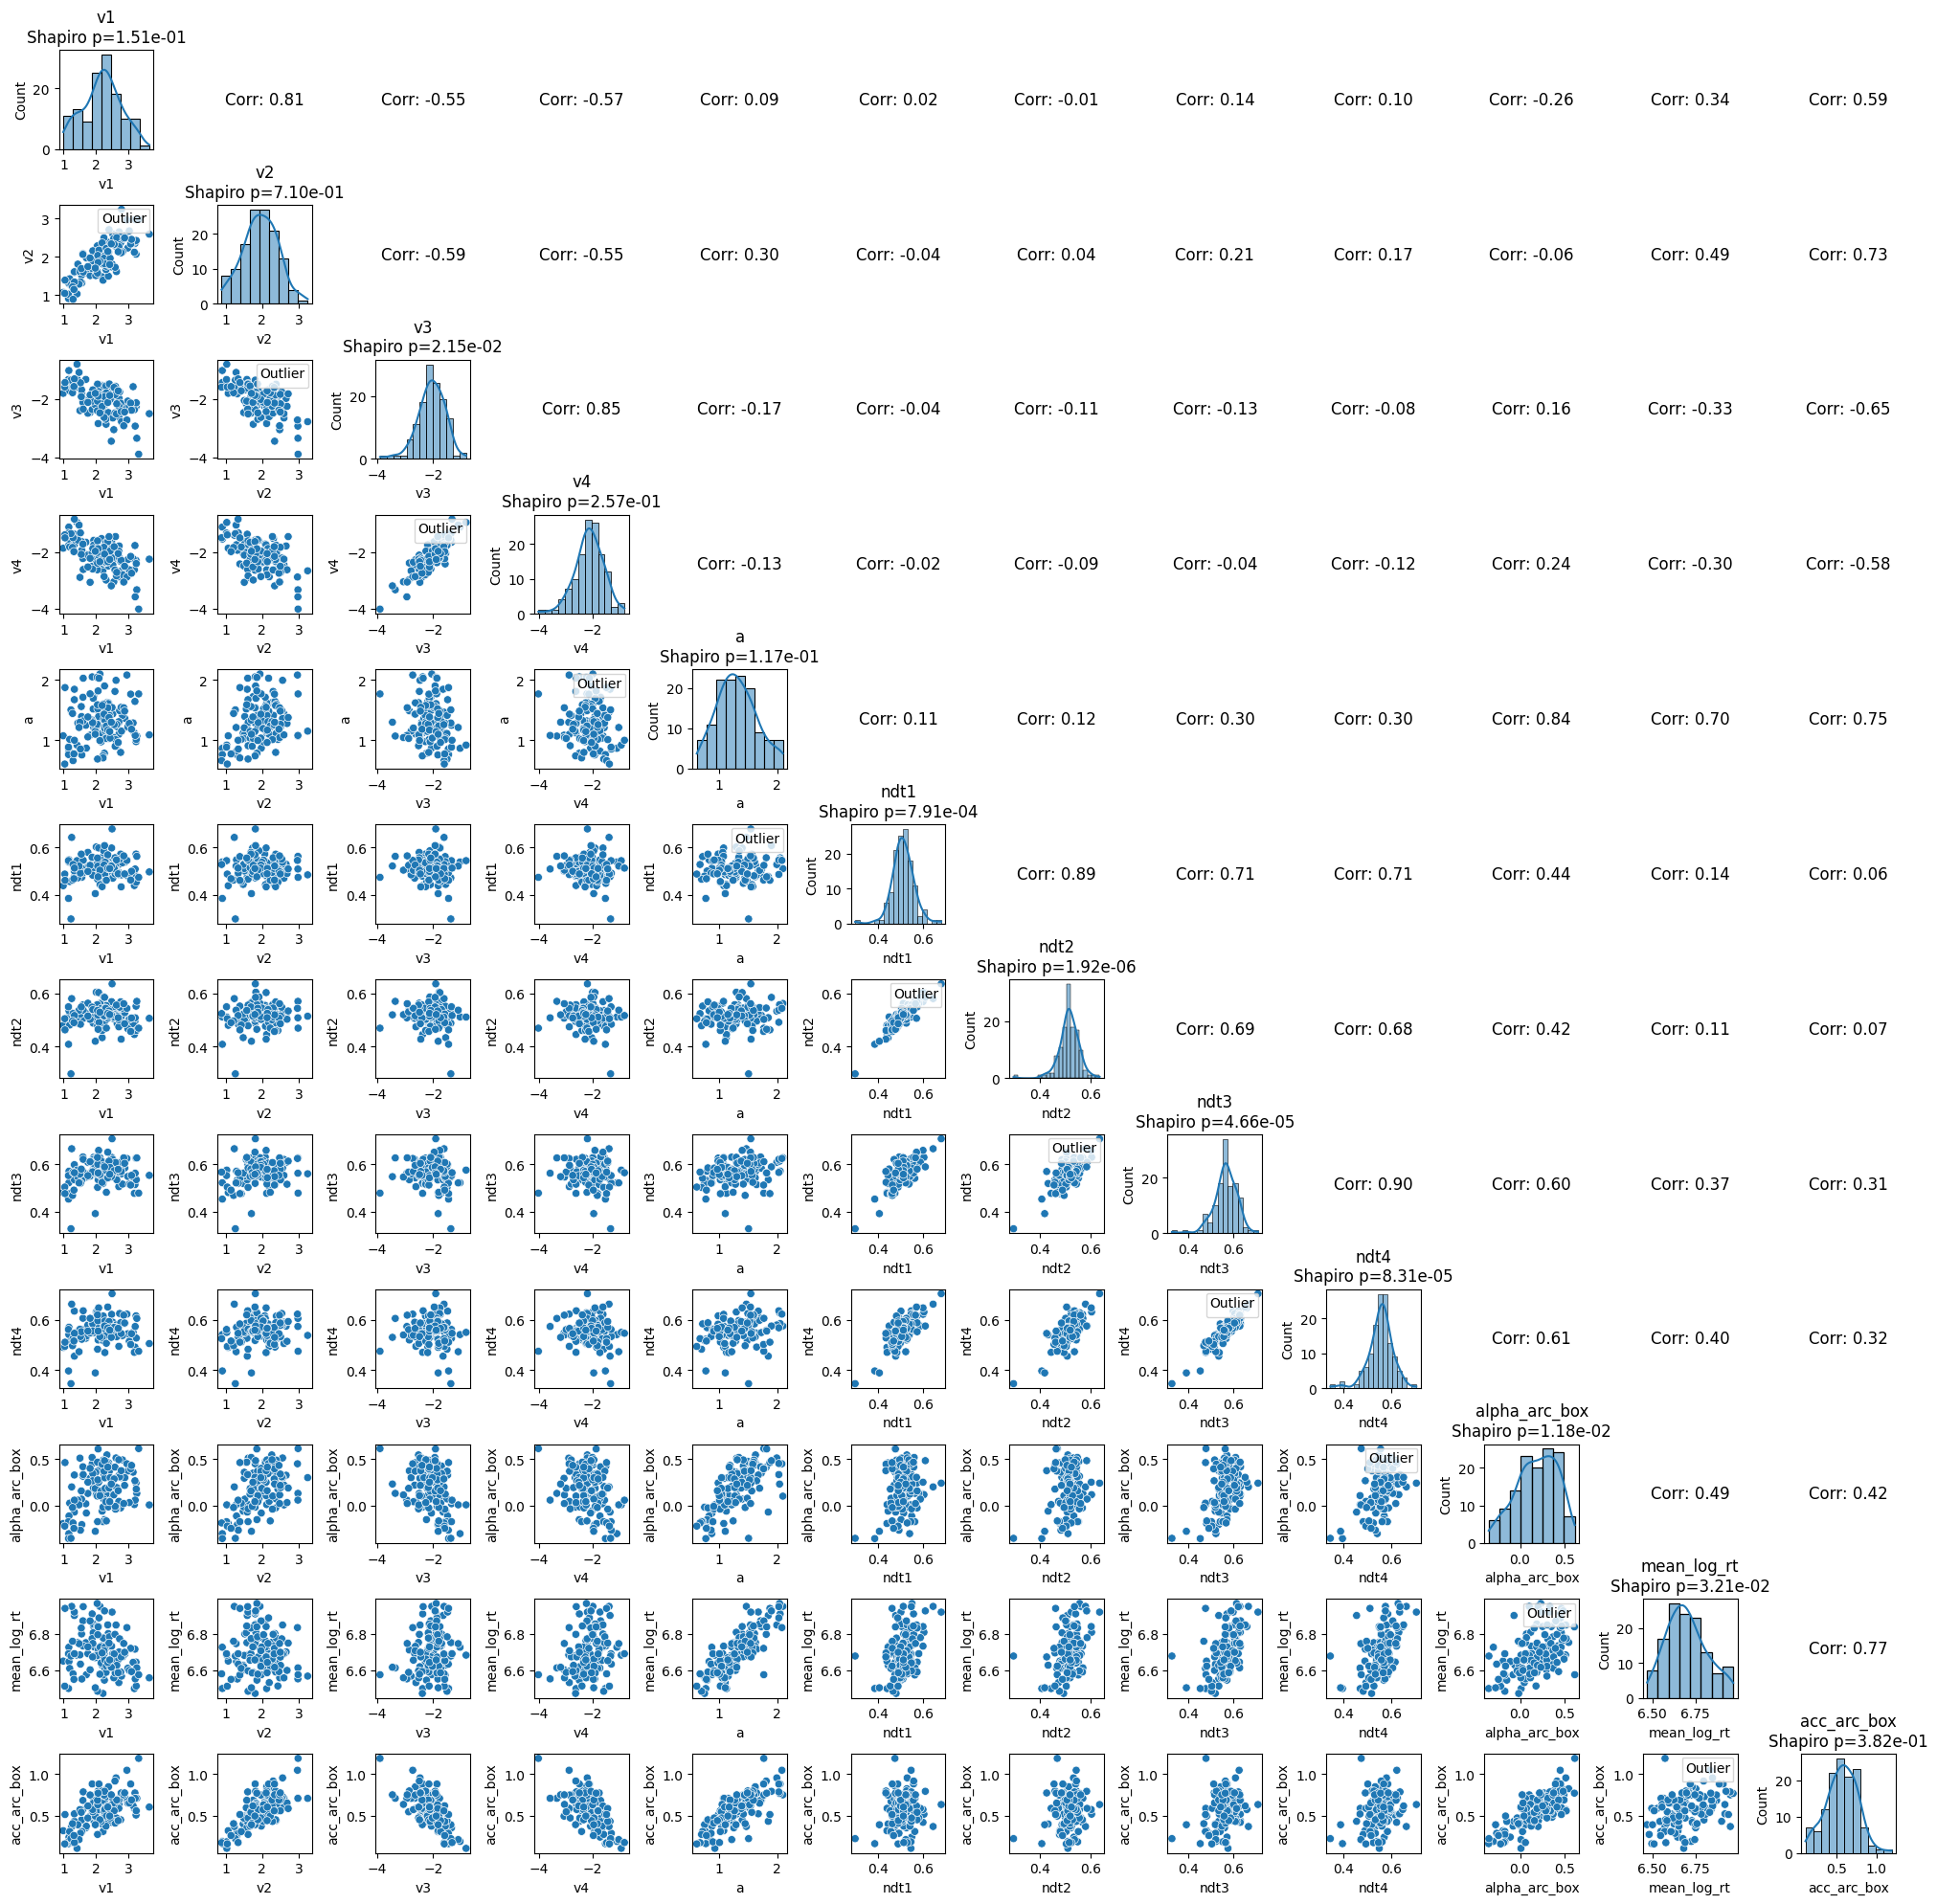

In [9]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('study2_associative_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean',
 'v2_mean',
 'v3_mean',
 'v4_mean',
# 'zr_mean',
 'a_mean',
 'ndt1_mean',
 'ndt2_mean',
 'ndt3_mean',
 'ndt4_mean',
# 'sndt_mean',
# 'alpha_mean',
    'mean_log_rt',
    'alpha_mean_boxcox_after_arcsin',
    'accuracy_percentage_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2','v3_mean': 'v3','v4_mean': 'v4',
   # 'zr_mean': 'zr', 
    'a_mean': 'a', 
    'ndt1_mean': 'ndt1','ndt2_mean': 'ndt2','ndt3_mean': 'ndt3','ndt4_mean': 'ndt4',
    #'sndt_mean': 'sndt', 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
           # plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.show()
plt.savefig('APT_S1_correlation_matrix_plot.png')  # Saves the plot to a file
plt.close()



In [10]:
correlation_matrix_renamed

v1        v2        v3        v4         a      ndt1  \
v1                  NaN  0.811411 -0.552538 -0.572278  0.088523  0.017366   
v2             0.811411       NaN -0.586018 -0.550648  0.302157 -0.041346   
v3            -0.552538 -0.586018       NaN  0.852226 -0.172219 -0.042138   
v4            -0.572278 -0.550648  0.852226       NaN -0.125108 -0.020985   
a              0.088523  0.302157 -0.172219 -0.125108       NaN  0.114676   
ndt1           0.017366 -0.041346 -0.042138 -0.020985  0.114676       NaN   
ndt2          -0.014895   0.03714 -0.108154 -0.088236  0.116802  0.890822   
ndt3           0.138517   0.20508 -0.129189 -0.038042   0.29897  0.709826   
ndt4           0.099597  0.165615 -0.075202 -0.115834  0.299719  0.713064   
mean_log_rt   -0.258663 -0.062546  0.159223  0.243072  0.841234  0.442477   
alpha_arc_box   0.33775  0.486768 -0.334871 -0.304832  0.695112  0.141851   
acc_arc_box    0.590433  0.729768 -0.647848 -0.578578  0.754255  0.055056   

                   ndt2      ndt3      ndt4 mean_log_rt alpha_arc_box  \
v1            -0.014895  0.138517  0.099597   -0.258663       0.33775   
v2              0.03714   0.20508  0.165615   -0.062546      0.486768   
v3            -0.108154 -0.129189 -0.075202    0.159223     -0.334871   
v4            -0.088236 -0.038042 -0.115834    0.243072     -0.304832   
a              0.116802   0.29897  0.299719    0.841234      0.695112   
ndt1           0.890822  0.709826  0.713064    0.442477      0.141851   
ndt2                NaN  0.691055  0.675371    0.421089       0.11256   
ndt3           0.691055       NaN  0.903214    0.598858      0.371873   
ndt4           0.675371  0.903214       NaN     0.60873      0.398752   
mean_log_rt    0.421089  0.598858   0.60873         NaN      0.485613   
alpha_arc_box   0.11256  0.371873  0.398752    0.485613           NaN   
acc_arc_box    0.070279  0.309231  0.316315    0.417856      0.773897   

              acc_arc_box  
v1               0.590433  
v2               0.729768  
v3              -0.647848  
v4              -0.578578  
a                0.754255  
ndt1             0.055056  
ndt2             0.070279  
ndt3             0.309231  
ndt4             0.316315  
mean_log_rt      0.417856  
alpha_arc_box    0.773897  
acc_arc_box           NaN